In [35]:
#adapted from http://mlbernauer.com/R/20160131-document-retrieval-sklearn.html

In [11]:
import os
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from collections import defaultdict

In [12]:
os.getcwd()

'/Users/ptighe/Documents/Python Projects/AcutePainOntology/medline_testing'

In [13]:
path='pubmed_result_medline.txt'

In [14]:
#Taken directly from reference:

In [15]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
def read_medline_data(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "authors", "affiliation", "grant",
                                   "abstract", "pubdate"])
    count = 0
    for rec in recs:
        try:
            abstr = rec["AB"]
            atitle = rec["TI"]
            auths = rec["AU"]
            pubdate = rec["DP"]
            jtitle = rec["JT"]
            grant=rec["GR"]
            pmid = rec['PMID']
            affil = rec['AD']
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle, auths, affil,grant, abstr,pubdate]],
                                     columns=["pmid", "articletitle", "journaltitle", "authors", "affiliation", 
                                              "grant", "abstract", "pubdate"]),ignore_index=True)            
        except:
            pass
    return text

In [16]:
# Read in MEDLINE formatted text
papers = read_medline_data(path)

In [17]:
papers.loc[0,'abstract']

'BACKGROUND: Consensus indicates that a comprehensive,multimodal, holistic approach is foundational to the practice of acute pain medicine (APM),but lack of uniform, evidence-based clinical pathways leads to undesirable variability throughout U. S. healthcare systems. Acute pain studies are inconsistently synthesized to guide educational programs. Advanced practice techniques involving regional anesthesia assume the presence of a physician-led, multidisciplinary acute pain service,which is often unavailable or inconsistently applied.This heterogeneity of educational and organizational standards may result in unnecessary patient pain and escalation of healthcare costs. METHODS: A multidisciplinary panel was nominated through the APM Shared Interest Group of the American Academy of Pain Medicine. The panel met in Chicago, IL, in July 2014, to identify gaps and set priorities in APM research and education. RESULTS: The panel identified three areas of critical need: 1) an open-source acute

In [18]:
#Need to find a list of subheadings to remove?

shp = re.compile(r'^[A-Z\d]+$')

subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:",
              u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:"]

In [20]:
#Now some items for cleaning the abstract text
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
stoplist.extend(['\x0c', '\n'])
subheadings =[u"OBJECTIVES:", u"OBJECTIVE:", u"AIMS:", u"OBJECTIVE/BACKGROUND:",
              u"METHODS AND RESULTS:", u"CONCLUSIONS:", u"RESULTS:", u"METHODS:", u"INTRODUCTION:", u"BACKGROUND:"]

In [21]:
papers['split_abstract'] = papers['abstract'].str.split()
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in subheadings])
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: ' '.join(x).lower().split())
papers['split_abstract'] = papers['split_abstract'].apply(lambda x: [item for item in x if item not in stoplist])

In [22]:
papers['cleaned_abstract']=papers['split_abstract'].apply(lambda x: ' '.join(x))
papers['cleaned_abstract']=papers['cleaned_abstract'].str.replace("[^a-zA-Z]"," ").str.replace("\s+"," ").str.strip()

In [23]:
papers['cleaned_abstract']

0     consensus indicates comprehensive multimodal h...
1     older adults increased risk develop frequent p...
2     prior work postoperative pain trajectories exa...
3     given ability process highly dimensional datas...
4     despite widespread popularity social media lit...
5     objective study determine effects age sex type...
6     prior work addressed sex differences incidence...
7     although prior work investigated interplay dem...
8     american academy pain medicine american societ...
9     goal project explore association post anesthes...
10    recent years field acute pain medicine apm wit...
11    purpose project determine whether machine lear...
12    although million patients united states underg...
Name: cleaned_abstract, dtype: object

In [24]:
papers['split_articletitle'] = papers['articletitle'].str.split()
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: ' '.join(x).lower().split())
papers['split_articletitle'] = papers['split_articletitle'].apply(lambda x: [item for item in x if item not in stoplist])
papers['cleaned_articletitle']=papers['split_articletitle'].apply(lambda x: ' '.join(x))
papers['cleaned_articletitle']=papers['cleaned_articletitle'].str.replace("[^a-zA-Z]"," ").str.replace("\s\s+"," ")

In [25]:
papers['cleaned_articletitle']

0      acute pain medicine united states status report 
1     age differences cytokine expression conditions...
2     time onset sustained postoperative pain relief...
3     teaching machine feel postoperative pain combi...
4     painful tweet text sentiment community structu...
5     clinically derived early postoperative pain tr...
6     sex differences incidence severe pain events f...
7     geospatial analysis hospital consumer assessme...
8                   acute pain medicine anesthesiology 
9     rough starts smooth finishes correlations post...
10              evolution practice acute pain medicine 
11    use machine learning classifiers predict reque...
12    primary payer status associated use nerve bloc...
Name: cleaned_articletitle, dtype: object

In [26]:
papers['ca_tokens'] =papers['cleaned_abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ra_tokens'] =papers['abstract'].map(lambda text: nltk.tokenize.word_tokenize(text))
papers['ra_tokens']


0     [BACKGROUND, :, Consensus, indicates, that, a,...
1     [Older, adults, are, at, an, increased, risk, ...
2     [OBJECTIVES, :, Prior, work, on, postoperative...
3     [BACKGROUND, :, Given, their, ability, to, pro...
4     [BACKGROUND, :, Despite, the, widespread, popu...
5     [The, objective, of, this, study, was, to, det...
6     [OBJECTIVE/BACKGROUND, :, Prior, work, has, no...
7     [Although, prior, work, has, investigated, the...
8     [The, American, Academy, of, Pain, Medicine, a...
9     [OBJECTIVE, :, The, goal, of, this, project, w...
10    [BACKGROUND, :, In, recent, years, ,, the, fie...
11    [OBJECTIVE, :, The, purpose, of, this, project...
12    [INTRODUCTION, :, Although, more, than, 30, mi...
Name: ra_tokens, dtype: object

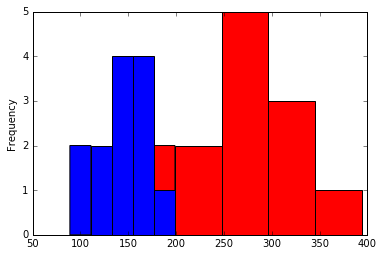

In [27]:
#These give token counts
papers['rabs_length'] =papers['ra_tokens'].map(lambda text: len(text))
papers['cabs_length'] =papers['ca_tokens'].map(lambda text: len(text))
papers.rabs_length.plot(bins=5, kind='hist', color='r')
papers.cabs_length.plot(bins=5, kind='hist')

In [28]:
papers['cabs_u_length'] =papers['ca_tokens'].map(lambda text: len(set(text)))
papers['cabs_u_length']

0     137
1      83
2      88
3      90
4     101
5      95
6      96
7      94
8      68
9      91
10     83
11    105
12    109
Name: cabs_u_length, dtype: int64

In [73]:
fd = papers['ca_tokens'].map(lambda text: nltk.FreqDist(text))


0     {'three': 1, 'critical': 1, 'debilitating': 1,...
1     {'generally': 1, 'compared': 1, 'assertion': 1...
2     {'discussion': 1, 'event': 2, 'necessary': 1, ...
3     {'compared': 1, 'predicting': 2, 'comparison':...
4     {'cities': 2, 'median': 2, 'social': 4, 'compa...
5     {'role': 1, 'interval': 1, 'biopsychosocial': ...
6     {'compared': 1, 'nursing': 1, 'prior': 1, 'cen...
7     {'rates': 1, 'evaluate': 1, 'healthcare': 1, '...
8     {'deeper': 1, 'well': 1, 'include': 1, 'unders...
9     {'median': 4, 'consistent': 1, 'reviewed': 1, ...
10    {'nomenclature': 1, 'discussion': 1, 'role': 2...
11    {'compared': 1, 'classifiers': 9, 'improved': ...
12    {'interval': 1, 'freestanding': 1, 'reviewed':...
Name: ca_tokens, dtype: object

In [30]:
#Word counts and such using CountVectorizer from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

In [31]:
ca_tdm = pd.DataFrame(vectorizer.fit_transform(papers.cleaned_abstract).toarray(),columns=vectorizer.get_feature_names())

In [32]:
ca_tdm

,ability,absolute,academic,academy,according,account,accounted,accredited,accuracies,accuracy,...,without,witnessed,word,work,would,year,years,yield,yielded,younger
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2,1,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
train_data_features = vectorizer.fit_transform(papers['cleaned_abstract'])
train_data_features = train_data_features.toarray()

In [20]:
print (train_data_features.shape)

(13, 796)


In [22]:
vocab = vectorizer.get_feature_names()
print (vocab)

['ability', 'absolute', 'academic', 'academy', 'according', 'account', 'accounted', 'accredited', 'accuracies', 'accuracy', 'achieving', 'across', 'actual', 'acute', 'addition', 'additional', 'addressed', 'administration', 'administrators', 'adult', 'adults', 'advanced', 'advancement', 'adverse', 'adversely', 'affect', 'age', 'aging', 'aim', 'aimed', 'algorithm', 'algorithms', 'allocation', 'alpha', 'also', 'alternative', 'although', 'always', 'ambulatory', 'american', 'among', 'amongst', 'analgesia', 'analyses', 'analysis', 'analyze', 'analyzed', 'anatomic', 'anesthesia', 'anesthesiology', 'anesthetics', 'angeles', 'anti', 'apm', 'apple', 'application', 'applied', 'approach', 'approximately', 'aps', 'area', 'areas', 'array', 'assertion', 'assessment', 'assessments', 'associated', 'association', 'assume', 'autoregressive', 'average', 'averages', 'based', 'baseline', 'bayesian', 'begun', 'beyond', 'biopsychosocial', 'block', 'blocks', 'blood', 'boosted', 'briefly', 'but', 'ca', 'calcula

In [24]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

3 ability
1 absolute
1 academic
2 academy
2 according
2 account
1 accounted
1 accredited
1 accuracies
2 accuracy
1 achieving
3 across
1 actual
19 acute
2 addition
1 additional
2 addressed
1 administration
1 administrators
4 adult
4 adults
1 advanced
1 advancement
1 adverse
1 adversely
3 affect
6 age
1 aging
2 aim
1 aimed
4 algorithm
4 algorithms
1 allocation
2 alpha
2 also
1 alternative
3 although
1 always
7 ambulatory
3 american
3 among
1 amongst
1 analgesia
6 analyses
4 analysis
1 analyze
1 analyzed
1 anatomic
6 anesthesia
1 anesthesiology
3 anesthetics
1 angeles
1 anti
12 apm
2 apple
1 application
1 applied
1 approach
1 approximately
5 aps
3 area
2 areas
1 array
1 assertion
2 assessment
1 assessments
2 associated
4 association
1 assume
1 autoregressive
1 average
1 averages
3 based
2 baseline
1 bayesian
1 begun
1 beyond
2 biopsychosocial
9 block
1 blocks
1 blood
2 boosted
1 briefly
1 but
1 ca
2 calculated
4 care
2 carry
2 case
3 cases
1 catheter
1 center
1 central
1 challenge
3 chang

In [52]:
#Another, slightly more robust approach from http://blog.yhat.com/posts/predict-weather-with-kaggle-twitter-emoticons-pandas.html

ca = papers['cleaned_abstract'].tolist()
vectorizer = CountVectorizer(
                             analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)
vectorizer.fit(ca)
x = vectorizer.transform(ca)
x

<13x796 sparse matrix of type '<class 'numpy.int64'>'
	with 1225 stored elements in Compressed Sparse Row format>

In [ ]:
def pull_sentences(filename):
    """
        Breaks abstract into sentences
        """

    print "\nTokenizing abstract\n\n"
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    fp = open(filename)
    data = fp.read()
    return tokenizer.tokenize(data.decode('utf-8'))


In [ ]:
def create_word2vec_sentence(sentence_list, stoplist):
    print "\nCreating word2vec sentences\n\n"
    retList = list()
    toolbar_width = len(sentence_list)
    for i, sentence in enumerate(sentence_list):

        p = str((float(i+1)/toolbar_width)*100)[:4]
        sys.stdout.write("\r%s%%" %p)
        sys.stdout.flush()

        sentLst = [x.strip(",").rstrip(".").strip(":").lower() for x in sentence.split(" ") if x.strip(",").strip(".").strip(":").lower() not in stoplist]
        retList.append(sentLst)
    return retList

In [87]:
#Can try this later
stemmer = nltk.SnowballStemmer("english")
lemmer = nltk.WordNetLemmatizer()
papers['stemab_p']= papers['cleaned_abstract'].str.split()
papers['stemab']= papers['cleaned_abstract'].map(lambda x: lemmer.lemmatize(x))